# Introduction and Motivation

In the era of digital media, music streaming platforms have transformed how we discover and enjoy music. Services like Spotify have millions of tracks available at our fingertips, making music recommendation systems essential for enhancing user experience. Recognizing the significance of these systems, our team chose to explore the “Spotify Tracks, Genre, Audio Features” dataset from Kaggle (https://www.kaggle.com/datasets/pepepython/spotify-huge-database-daily-charts-over-3-years/data) using PySpark to analyze trends and build a music recommendation model.

Our motivation for selecting this dataset is rooted in a desire to engage with a more intriguing and relatable subject matter than the typical technical datasets we’ve encountered in previous classes. Music is a universal language, and understanding how recommendation systems work within this context is both exciting and relevant. Music recommendation models are increasingly important as the amount of data generated online continues to grow, impacting how users interact with streaming services.

The primary objectives of our project are twofold:
1. Data Analysis: We aim to understand trends within the music data by examining how different genres relate to specific audio feature metrics. For example, we want to investigate whether certain genres consistently exhibit higher danceability scores or how energy levels vary across genres.
2. Model Building: Utilizing machine learning techniques, we plan to develop a music recommendation model. This model will leverage the insights gained from our data analysis to suggest tracks that align with user preferences based on audio features.

Our project focuses on mainstream music, as the dataset predominantly features popular tracks. While we have considered algorithms like K-Nearest Neighbors for recommendation, we will determine the most suitable machine learning methods as we progress, ensuring they align with our dataset characteristics and project goals.

# Data Collection

In [8]:
from pyspark.sql import SparkSession


if SparkSession._instantiatedSession is not None:
    print("An existing SparkSession is detected.")
    SparkSession._instantiatedSession.stop()


# Initialize a Spark session
# Start a new Spark session
spark = SparkSession.builder \
    .appName("MusicDataAnalysisProject") \
    .config("spark.driver.memory", "4g") \
    .config("spark.driver.bindAddress", "127.0.0.1") \
    .getOrCreate() 
    

spark.sparkContext.setLogLevel("ERROR")

# Path to your CSV file
csv_path = "../Music_Database.csv"

music_df = spark.read.option("header", "true").csv(csv_path, inferSchema=True)
music_df = music_df.withColumnRenamed("Country", "Country0")

# Show the first few rows to verify
music_df.show()


An existing SparkSession is detected.
+-----------+--------------------+------------------+---------------+--------------------+------------+-----------------+----------------+--------+--------------------+------------+------------+---------------+------------------+------------------+---+--------+----+-----------+-------------------+----------------+----------+-------+-------+-----------+--------------+---------+------------------+-------------------+--------------+-------------+-------+-----------+------+------+--------+---------+----------------+----+----+-------+-----+-----+----+-----+-----+-----+---+---+--------+---+------+---------+----+----+------------+---------+----------+--------+-------+----+-----+----+-----+------------+-------+----+----+-------+--------+-----+--------+--------+-------+----------+-------------------+------------+-------------------+-------------------+------------------+-------------+-------------------+------------------+-------------------+-----------+---

# Data Inspection and Validation

Numerical columns are String in the schema, so we'll convert them to numeric types later on (Data Transformation).

In [2]:
# Print the schema of the DataFrame
music_df.printSchema()

root
 |-- Country0: string (nullable = true)
 |-- Uri: string (nullable = true)
 |-- Popularity: double (nullable = true)
 |-- Title: string (nullable = true)
 |-- Artist: string (nullable = true)
 |-- Album/Single: string (nullable = true)
 |-- Genre: string (nullable = true)
 |-- Artist_followers: string (nullable = true)
 |-- Explicit: string (nullable = true)
 |-- Album9: string (nullable = true)
 |-- Release_date: string (nullable = true)
 |-- Track_number: string (nullable = true)
 |-- Tracks_in_album: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- key: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- speechiness: string (nullable = true)
 |-- acoustics: string (nullable = true)
 |-- instrumentalness: string (nullable = true)
 |-- liveliness: string (nullable = true)
 |-- valence: string (nullable = true)
 |-- tempo: string (nullable = true)
 |-- duration_ms: 

Check for null and duplicates in the dataset. Also, check the distribution of popularity scores because later we will categoprize the data by low, medium, and high popularity levels.

In [3]:
from pyspark.sql.functions import col, sum, count, when
# Count null values in each column
null_counts = music_df.select([count(when(col(c).isNull(), c)).alias(c) for c in music_df.columns])
null_counts.show()

# Check for duplicates
duplicate_count = music_df.count() - music_df.dropDuplicates().count()
print(f"Number of duplicate rows: {duplicate_count}")

# Check popularity range for validity (e.g., ensure no extreme outliers)
music_df.select("Popularity").describe().show()


+--------+---+----------+-----+------+------------+-----+----------------+--------+------+------------+------------+---------------+------------+------+---+--------+----+-----------+---------+----------------+----------+-------+-----+-----------+--------------+---------+------------------+-------------------+--------------+-------------+-------+-----------+------+------+--------+---------+----------------+----+----+-------+-----+-----+----+-----+-----+-----+---+---+--------+---+------+---------+----+----+------------+---------+----------+--------+-------+-----+-----+-----+-----+------------+-------+-----+-----+-------+--------+-----+--------+--------+-------+----------+-----------------+------------+---------+--------+------------+-------------+----------+-------------+-------------+-----------+------------------+-------------+----------+---------+-------------+--------------+-----------+--------------+--------------+---------------+---------------+-----+--------------+-------------+--

Number of duplicate rows: 0
+-------+------------------+
|summary|        Popularity|
+-------+------------------+
|  count|            170633|
|   mean| 5417.616264145855|
| stddev|13115.854525897726|
|    min|               0.8|
|    max|233766.89999999988|
+-------+------------------+



# Data Filtering

In [4]:
# Further refine by North America
filtered_df = music_df.filter((music_df.Country0 == "USA") | (music_df.Country0 == "Canada") | (music_df.Country0 == "Mexico"))

print(f"Number of rows: {filtered_df.count()}")


Number of rows: 15113


# Data Transformation

In [ ]:
from pyspark.sql.functions import col

# List of columns to cast to integer or double as appropriate
int_columns = ["Track_number", "Tracks_in_album", "time_signature", "Argentina", "Australia", "Austria", 
               "Belgium", "Brazil", "Canada", "Chile", "Colombia", "Costa Rica", "Denmark", "Ecuador", 
               "Finland", "France", "Germany", "Global", "Indonesia", "Ireland", "Italy", "Malaysia", 
               "Mexico", "Netherlands", "New Zealand", "Norway", "Peru", "Philippines", "Poland", 
               "Portugal", "Singapore", "Spain", "Sweden", "Switzerland", "Taiwan", "Turkey", "UK", "USA"]

double_columns = ["Popularity", "Artist_followers", "danceability", "energy", "key", "loudness", 
                  "mode", "speechiness", "acoustics", "instrumentalness", "liveliness", "valence", 
                  "tempo", "duration_ms", "Days_since_release", "syuzhet_norm", "bing_norm", "afinn_norm", 
                  "nrc_norm", "syuzhet", "bing", "afinn", "nrc", "anger", "anticipation", "disgust", "fear", 
                  "joy", "sadness", "surprise", "trust", "negative", "positive", "n_words", "anger_norm", 
                  "anticipation_norm", "disgust_norm", "fear_norm", "joy_norm", "sadness_norm", "surprise_norm", 
                  "trust_norm", "negative_norm", "positive_norm", "anger_norm2", "anticipation_norm2", 
                  "disgust_norm2", "fear_norm2", "joy_norm2", "sadness_norm2", "surprise_norm2", "trust_norm2", 
                  "negative_norm2", "positive_norm2", "negative_bog_jr", "positive_bog_jr", "Bayes", 
                  "Negative_Bayes", "Neutral_Bayes", "Positive_Bayes", "Desire", "Explore", "Fun", 
                  "Hope", "Love", "Nostalgia", "Thug", "bing_norm_negative"]

# Cast columns to integer
for column in int_columns:
    filtered_df = filtered_df.withColumn(column, col(column).cast("int"))

# Cast columns to double
for column in double_columns:
    filtered_df = filtered_df.withColumn(column, col(column).cast("double"))

# Assign to transformed_df to avoid confusion
transformed_df = filtered_df

# Verify the updated schema
transformed_df.printSchema()


root
 |-- Country0: string (nullable = true)
 |-- Uri: string (nullable = true)
 |-- Popularity: double (nullable = true)
 |-- Title: string (nullable = true)
 |-- Artist: string (nullable = true)
 |-- Album/Single: string (nullable = true)
 |-- Genre: string (nullable = true)
 |-- Artist_followers: double (nullable = true)
 |-- Explicit: string (nullable = true)
 |-- Album9: string (nullable = true)
 |-- Release_date: string (nullable = true)
 |-- Track_number: integer (nullable = true)
 |-- Tracks_in_album: integer (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: double (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acoustics: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveliness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- duration_ms

# Clustering

In [15]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType
import numpy as np

# Select feature columns for clustering
feature_columns = ["danceability", "energy", "valence", "tempo", "loudness", "speechiness", "acoustics", "instrumentalness", "liveliness"]

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
assembled_df = assembler.transform(transformed_df)

# Standardize features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(assembled_df)
scaled_df = scaler_model.transform(assembled_df)

# Apply K-Means clustering
kmeans = KMeans(featuresCol="scaled_features", k=5, seed=1)  # k=5 as an example
kmeans_model = kmeans.fit(scaled_df)

# Make predictions
clusters_df = kmeans_model.transform(scaled_df)

# Show cluster assignments
clusters_df.select("scaled_features", "prediction").show(truncate=False)

# Function to calculate squared Euclidean distance
def squared_distance(point, centroid):
    return float(np.sum((np.array(point) - np.array(centroid)) ** 2))

# Get cluster centers as a broadcast variable
centroids = kmeans_model.clusterCenters()
broadcast_centroids = spark.sparkContext.broadcast(centroids)

# UDF to compute squared distance
@udf(DoubleType())
def compute_squared_distance(point, cluster_id):
    centroid = broadcast_centroids.value[cluster_id]
    return squared_distance(point, centroid)

# Add a column with squared distances
clusters_df = clusters_df.withColumn(
    "squared_distance",
    compute_squared_distance("scaled_features", "prediction")
)

# Compute WSSSE by summing squared distances
wssse = clusters_df.select("squared_distance").rdd.map(lambda row: row[0]).sum()
print(f"Within Set Sum of Squared Errors (WSSSE): {wssse}")

# Analyze clusters
clusters_df.groupBy("prediction").count().show()

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|scaled_features                                                                                                                                                                          |prediction|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|[0.40377839731503035,0.4999116709600466,1.070868308987517,1.6532407905437325,0.8024277503534322,1.582979658401099,0.39211557897389626,-0.15679316881087688,-0.8117222855356261]          |2         |
|[0.40377839731503035,0.4999116709600466,1.070868308987517,1.6532407905437325,0.8024277503534322,1.582979658401099,0.39211557897389626,-0.15679316881087688,-0.8117222855356261]          |2         |
|[-0.

In [17]:
# Group by cluster (prediction) and genre, then count occurrences
genre_distribution = clusters_df.groupBy("prediction", "genre").count()

# Show the genre distribution for each cluster
genre_distribution.orderBy("prediction", "count", ascending=[True, False]).show(truncate=False)

# Pivot the table to make genres columns
genre_pivot = genre_distribution.groupBy("prediction").pivot("genre").sum("count")

# Replace nulls with 0 for easier analysis
genre_pivot = genre_pivot.fillna(0)

# Show the resulting table
genre_pivot.show(truncate=False)

+----------+--------------------+-----+
|prediction|genre               |count|
+----------+--------------------+-----+
|0         |dance pop           |229  |
|0         |hip hop             |127  |
|0         |latin               |80   |
|0         |atl hip hop         |73   |
|0         |conscious hip hop   |68   |
|0         |detroit hip hop     |64   |
|0         |canadian hip hop    |53   |
|0         |pop                 |52   |
|0         |contemporary country|47   |
|0         |melodic rap         |41   |
|0         |chicago rap         |32   |
|0         |alternative hip hop |31   |
|0         |emo rap             |29   |
|0         |boy band            |28   |
|0         |k-pop               |22   |
|0         |album rock          |22   |
|0         |alternative metal   |21   |
|0         |alternative r&b     |20   |
|0         |big room            |18   |
|0         |brostep             |16   |
+----------+--------------------+-----+
only showing top 20 rows

+----------+--

In [18]:
from pyspark.sql.functions import col, sum as _sum

# Calculate total count of each genre across all clusters
genre_totals = genre_distribution.groupBy("genre").agg(_sum("count").alias("total_count"))

# Filter genres with at least 30 entries
popular_genres = genre_totals.filter(col("total_count") >= 100).select("genre").rdd.flatMap(lambda x: x).collect()

# Pivot the table only for popular genres
filtered_pivot = genre_distribution.filter(col("genre").isin(popular_genres)) \
                                   .groupBy("prediction").pivot("genre").sum("count")

# Replace nulls with 0 for easier analysis
filtered_pivot = filtered_pivot.fillna(0)

# Show the resulting table
filtered_pivot.show(truncate=False)

+----------+---------------+----------+-----------------+---------------+-------+-----------+--------+------+--------+--------------+--------+-------------------------+----------------+------------+-----------+-------------+-----------------+--------------------+-------+---------+---------------+-------+---+----------+-------+-------+-----+-----+-----------+-----------+---+---+---+
|prediction|adult standards|album rock|alternative metal|alternative r&b|art pop|atl hip hop|big room|bolero|boy band|brooklyn drill|cali rap|canadian contemporary r&b|canadian hip hop|canadian pop|chicago rap|colombian pop|conscious hip hop|contemporary country|corrido|dance pop|detroit hip hop|dfw rap|edm|electropop|emo rap|hip hop|k-pop|latin|melodic rap|modern rock|n-a|pop|rap|
+----------+---------------+----------+-----------------+---------------+-------+-----------+--------+------+--------+--------------+--------+-------------------------+----------------+------------+-----------+-------------+------

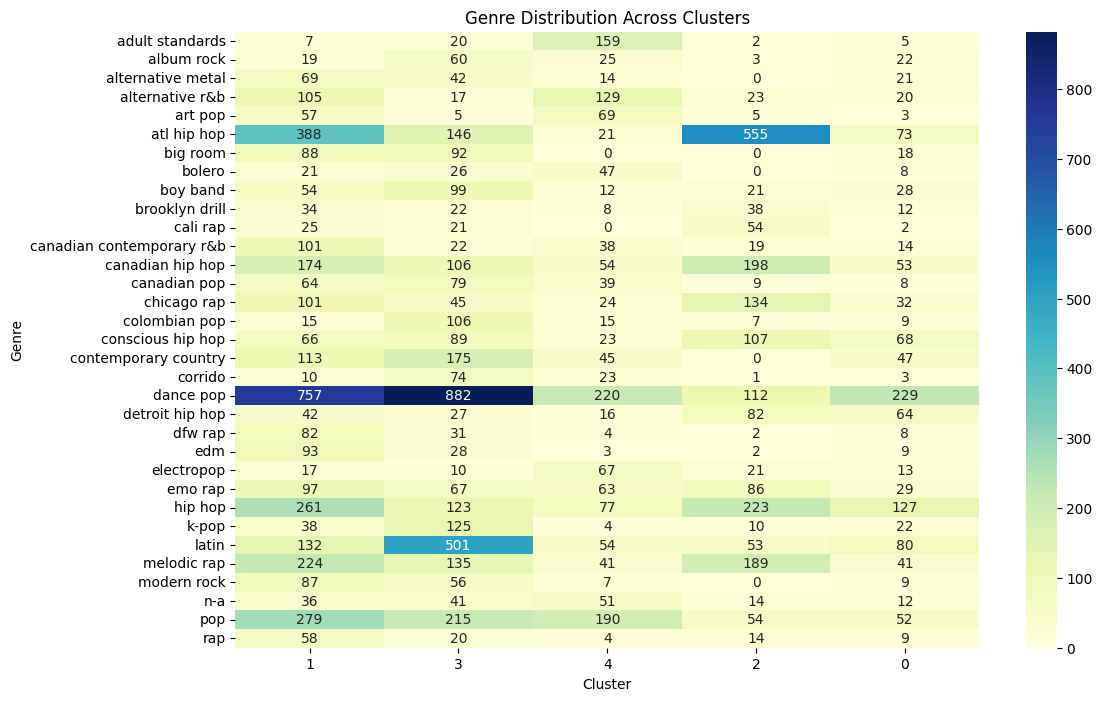

In [20]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas for heatmap visualization
genre_counts_pd = filtered_pivot.toPandas()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(genre_counts_pd.set_index("prediction").T, cmap="YlGnBu", annot=True, fmt="d")
plt.title("Genre Distribution Across Clusters")
plt.xlabel("Cluster")
plt.ylabel("Genre")
plt.show()

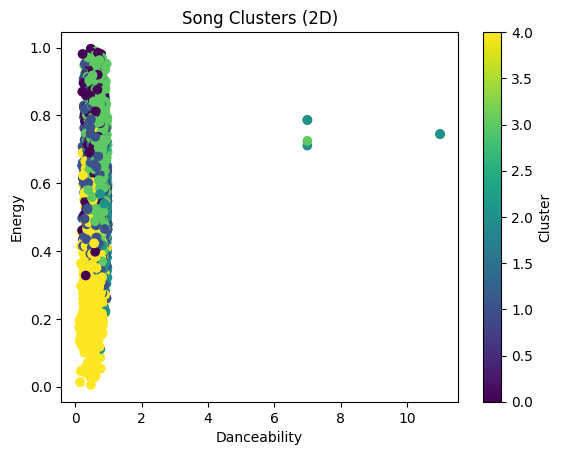

In [22]:
import matplotlib.pyplot as plt

# Sample 2D scatter plot
scatter_df = clusters_df.select("danceability", "energy", "prediction").toPandas()
plt.scatter(scatter_df["danceability"], scatter_df["energy"], c=scatter_df["prediction"], cmap="viridis")
plt.xlabel("Danceability")
plt.ylabel("Energy")
plt.title("Song Clusters (2D)")
plt.colorbar(label="Cluster")
plt.show()

# Model 2 (KNN Music Recommender)

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql import functions as F
from pyspark.sql.types import FloatType
from pyspark.sql import DataFrame

# Step 1: Aggregate features by Uri, retaining Title and Artist
model2_df = transformed_df.groupBy("Uri").agg(
    F.first("Title").alias("Title"),
    F.first("Artist").alias("Artist"),
    F.avg("danceability").alias("danceability"),
    F.avg("energy").alias("energy"),
    F.avg("loudness").alias("loudness"),
    F.avg("acoustics").alias("acoustics"),
    F.avg("instrumentalness").alias("instrumentalness"),
    F.avg("liveliness").alias("liveliness"),
    F.avg("valence").alias("valence"),
    F.avg("tempo").alias("tempo")
)

audio_features = ['danceability', 'energy', 'loudness', 'acoustics', 
                  'instrumentalness', 'liveliness', 'valence', 'tempo']
model2_df = model2_df.fillna(0, subset=audio_features)
# Combine audio features into a single vector column
assembler = VectorAssembler(inputCols=audio_features, outputCol="features")
data_with_features = assembler.transform(model2_df)  # Replace 'data' with your PySpark DataFrame



In [ ]:
# Step 2: Standardize the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(data_with_features)
data_scaled = scaler_model.transform(data_with_features)

In [ ]:
# Step 3: Define the recommendation function including Title and Artist in the output
def get_recommendations(df: DataFrame, target_uri: str, n_recommendations: int = 5) -> DataFrame:
    """
    Get song recommendations based on Euclidean distance to a target song by Uri.

    Parameters:
    df (DataFrame): The PySpark DataFrame containing scaled features.
    target_uri (str): The Uri of the target song.
    n_recommendations (int): Number of recommendations to retrieve.

    Returns:
    DataFrame: A PySpark DataFrame of recommended songs including Uri, Title, and Artist.
    """
    # Extract the feature vector of the target song by Uri
    target_song = df.where(F.col("Uri") == target_uri).select("scaled_features").first()
    
    # Check if target_song exists
    if not target_song:
        raise ValueError(f"Uri {target_uri} not found in the dataset.")
    
    target_vector = target_song["scaled_features"]

    # Define a UDF to calculate Euclidean distance
    def euclidean_distance(v1, v2):
        return float(v1.squared_distance(v2)) ** 0.5

    distance_udf = F.udf(lambda v: euclidean_distance(target_vector, v), FloatType())

    # Calculate distances and get the closest songs
    df_with_distances = df.withColumn("distance", distance_udf(F.col("scaled_features")))
    recommendations = (df_with_distances
                       .filter(F.col("Uri") != target_uri)  # Exclude the target song itself
                       .select("Uri", "Title", "Artist", "distance")  # Include Uri, Title, Artist
                       .orderBy("distance")
                       .limit(n_recommendations))
    
    return recommendations

In [ ]:
# Example usage:
recommendations_df = get_recommendations(data_scaled, target_uri="https://open.spotify.com/track/6FyRXC8tJUh863JCkyWqtk", n_recommendations=5)
recommendations_df.show()

+--------------------+------------------+--------------------+----------+
|                 Uri|             Title|              Artist|  distance|
+--------------------+------------------+--------------------+----------+
|https://open.spot...|        adan y eva|        Paulo Londra|0.04859169|
|https://open.spot...|la jeepeta - remix|Nio Garcia - Anue...|0.43462214|
|https://open.spot...|la jeepeta - remix|Nio Garcia - Anue...|0.44388047|
|https://open.spot...|       fuego lento|          Drake Bell| 0.5159253|
|https://open.spot...|     supuestamente|    Ozuna - Anuel AA|0.57871056|
+--------------------+------------------+--------------------+----------+

